In [10]:
import pandas as pd
#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


plt.style.use('classic')

In [11]:
# Read the data
from pathlib import Path
import ast

DATA_DIR = Path("..") /  "data" / "raw"

# Load CSVs
days_df = pd.read_csv(DATA_DIR / "days.csv")
photos_df = pd.read_csv(DATA_DIR / "photos.csv")

# Helper to parse list-like strings safely
def parse_list(value):
    if isinstance(value, list):
        return value
    if not isinstance(value, str) or value.strip() == "":
        return []
    try:
        parsed = ast.literal_eval(value)
        if isinstance(parsed, list):
            return parsed
    except Exception:
        pass
    return []

# Parse list columns
if "identified_species" in days_df.columns:
    days_df["identified_species_list"] = days_df["identified_species"].apply(parse_list)

if "species" in photos_df.columns:
    def parse_photo_species(val):
        lst = parse_list(val)
        # Handle list of dicts from new scraper format
        if lst and isinstance(lst, list) and len(lst) > 0 and isinstance(lst[0], dict):
            return [d.get('latin_name') for d in lst if isinstance(d, dict) and d.get('latin_name')]
        return lst
    photos_df["species_list"] = photos_df["species"].apply(parse_photo_species)

# Derive convenience columns
photos_df["first_species"] = photos_df["species_list"].apply(lambda xs: xs[0] if isinstance(xs, list) and xs else "Unidentified")
days_df["identified_species_count"] = days_df.get("identified_species_list", []).apply(lambda xs: len(xs) if isinstance(xs, list) else 0)

print(f"Days rows: {len(days_df)} | Photos rows: {len(photos_df)}")
print("Columns (days):", list(days_df.columns))
print("Columns (photos):", list(photos_df.columns))

Days rows: 1420 | Photos rows: 21528
Columns (days): ['date', 'url', 'weather_summary', 'identified_species_text', 'identified_species', 'kmz_url', 'photo_count', 'identified_species_list', 'identified_species_count']
Columns (photos): ['date', 'page_url', 'photo_url', 'index_on_page', 'full_caption', 'common_name', 'species', 'location_text', 'latitude', 'longitude', 'species_list', 'first_species']


In [12]:
# Filter to years with best coverage (2018-2024)
START_YEAR = 2018
END_YEAR = 2024

# Parse dates
days_df['date_dt'] = pd.to_datetime(days_df['date'])
photos_df['date_dt'] = pd.to_datetime(photos_df['date'])

# Filter both DataFrames
days_df = days_df[(days_df['date_dt'].dt.year >= START_YEAR) & (days_df['date_dt'].dt.year <= END_YEAR)].copy()
photos_df = photos_df[(photos_df['date_dt'].dt.year >= START_YEAR) & (photos_df['date_dt'].dt.year <= END_YEAR)].copy()

print(f"Filtered to {START_YEAR}-{END_YEAR}")
print(f"Days: {len(days_df)} | Photos: {len(photos_df)}")
print(f"Date range: {days_df['date_dt'].min().date()} to {days_df['date_dt'].max().date()}")

Filtered to 2018-2024
Days: 1259 | Photos: 20421
Date range: 2018-01-06 to 2024-11-15


In [13]:
# Species frequency analysis (with fallback)
from collections import Counter

photo_species_counter = Counter()
for lst in photos_df["species_list"]:
    photo_species_counter.update(lst)

species_freq_df = pd.DataFrame(photo_species_counter.items(), columns=["species", "occurrences"]).sort_values("occurrences", ascending=False)

# Fallback: if no per-photo species, aggregate identified species from days
if species_freq_df.empty and "identified_species_list" in days_df.columns:
    day_species_counter = Counter()
    for lst in days_df["identified_species_list"]:
        day_species_counter.update(lst)
    species_freq_df = pd.DataFrame(day_species_counter.items(), columns=["species", "occurrences"]).sort_values("occurrences", ascending=False)
    source_note = "(fallback: day-level identified species)"
else:
    source_note = "(photo-level species)"

print("Top 10 species by occurrences", source_note)
print(species_freq_df.head(10))

# Daily photo counts sanity check vs days_df.photo_count
photos_per_day = photos_df.groupby("date").size().rename("actual_photo_count").reset_index()
photo_count_compare = days_df[["date", "photo_count"]].merge(photos_per_day, on="date", how="left")
photo_discrepancies = photo_count_compare.query("photo_count != actual_photo_count")
print(f"Discrepancy rows: {len(photo_discrepancies)}")
photo_count_compare.head()

Top 10 species by occurrences (photo-level species)
                          species  occurrences
16       Desarmillaria caespitosa          114
55                 Boletus edulis          104
101              Lactarius indigo           83
230           Trametopsis cervina           79
390         Fibroporia radiculosa           79
18            Trametes versicolor           74
44   Pulchroboletus rubricitrinus           70
0              Xylodon flaviporus           69
264            Trichaptum biforme           68
306             Trametes lactinea           68
Discrepancy rows: 0


,date,photo_count,actual_photo_count
0,2024-11-15,2,2
1,2024-11-14,15,15
2,2024-11-12,4,4
3,2024-11-11,6,6
4,2024-11-10,4,4


## Taxonomy Filter: "Cool" Mushrooms Only

Filter to stalked, fleshy mushrooms - excluding shelf fungi (Trametes, etc.), crusts, slime molds, and lichens. 
Boletes are included (they're taxonomically distinct from polypores like Trametes).

In [14]:
# Load the mushroom taxonomy filter from YAML config
import sys
sys.path.insert(0, str(Path("..") / "src"))

from texas_mushrooms.config.filter_config import MushroomFilter

# Load filter configuration
config_path = Path("..") / "config" / "mushroom_filter.yaml"
mushroom_filter = MushroomFilter.from_yaml(config_path)
print(mushroom_filter)

# Show what gets excluded
from texas_mushrooms.pipeline.processing import get_exclusion_stats

exclusion_stats = get_exclusion_stats(
    photos_df, 
    mushroom_filter, 
    species_col="first_species",
    caption_col=None  # photos.csv may not have full_caption
)

print(f"\nTop 20 excluded species (total {len(exclusion_stats)}):")
print(exclusion_stats.head(20).to_string(index=False))

MushroomFilter(
  exclude_groups=4,
  exclude_genera=58,
  exclude_species=4,
  include_species=2,
  exclude_keywords=10
)

Top 20 excluded species (total 137):
                 species  count                           exclusion_reason
   Fibroporia radiculosa     79                 genus excluded: Fibroporia
     Trametes versicolor     73                   genus excluded: Trametes
      Xylodon flaviporus     69                    genus excluded: Xylodon
       Trametes lactinea     68                   genus excluded: Trametes
      Trichaptum biforme     64                 genus excluded: Trichaptum
 Daedaleopsis confragosa     64               genus excluded: Daedaleopsis
Xanthoparmelia conspersa     55             genus excluded: Xanthoparmelia
          Fuligo septica     54                     genus excluded: Fuligo
     Schizopora paradoxa     53                 genus excluded: Schizopora
        Phellinus gilvus     53                  genus excluded: Phellinus
         Fomes

In [ ]:
# Apply the filter to get only "cool" mushrooms
from texas_mushrooms.pipeline.processing import filter_photos_by_taxonomy

photos_cool = filter_photos_by_taxonomy(
    photos_df,
    mushroom_filter,
    species_col="first_species",
    caption_col=None,
)

print(f"Original photos: {len(photos_df)}")
print(f"Cool mushrooms:  {len(photos_cool)} ({len(photos_cool)/len(photos_df):.1%})")

# Rebuild species frequency for cool mushrooms only
from collections import Counter

cool_counter = Counter()
for lst in photos_cool["species_list"]:
    cool_counter.update(lst)

cool_species_freq = pd.DataFrame(
    cool_counter.items(), columns=["species", "occurrences"]
).sort_values("occurrences", ascending=False)

print(f"\nTop 15 'cool' mushroom species:")
print(cool_species_freq.head(15).to_string(index=False))

In [ ]:
# Compare species distributions: all vs cool mushrooms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# All species (top 15)
all_top = species_freq_df.head(15).copy()
all_top["species_short"] = all_top["species"].apply(lambda s: (s[:30] + "…") if len(s) > 30 else s)
sns.barplot(data=all_top, x="occurrences", y="species_short", ax=axes[0], palette="Reds_r")
axes[0].set_title("Top 15 Species (All)")
axes[0].set_xlabel("Occurrences")
axes[0].set_ylabel("")

# Cool species only (top 15)
cool_top = cool_species_freq.head(15).copy()
cool_top["species_short"] = cool_top["species"].apply(lambda s: (s[:30] + "…") if len(s) > 30 else s)
sns.barplot(data=cool_top, x="occurrences", y="species_short", ax=axes[1], palette="Greens_r")
axes[1].set_title("Top 15 Species (Cool Mushrooms)")
axes[1].set_xlabel("Occurrences")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

<bound method Series.reset_index of year
2007       5
2008      18
2009      31
2010      14
2011       5
2012      17
2013     289
2014      22
2017     706
2018    3848
2019    3105
2020    4038
2021    4277
2022    1937
2023    1873
2024    1343
Name: photo_count, dtype: int64>
    year  photo_count
0   2007            5
1   2008           18
2   2009           31
3   2010           14
4   2011            5
5   2012           17
6   2013          289
7   2014           22
8   2017          706
9   2018         3848
10  2019         3105
11  2020         4038
12  2021         4277
13  2022         1937
14  2023         1873
15  2024         1343


/var/folders/vq/z5__yt3d0zlgfw4cv_shfqv80000gn/T/ipykernel_28095/2268882261.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=photos_per_year, x='year', y='photo_count', palette='viridis')


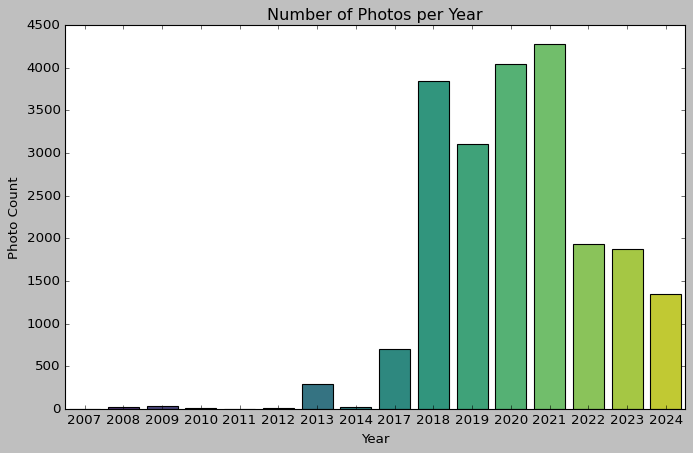

In [9]:
#print number of photos per year and some metric to show which years have best data coverage
photos_df['year'] = pd.to_datetime(photos_df['date']).dt.year
photos_per_year = photos_df.groupby('year').size().rename('photo_count').reset_index
print(photos_per_year)
photos_per_year = photos_df.groupby('year').size().rename('photo_count').reset_index()
print(photos_per_year)
# Visualize photos per year
plt.figure(figsize=(10, 6))
sns.barplot(data=photos_per_year, x='year', y='photo_count', palette='viridis')
plt.title('Number of Photos per Year')
plt.xlabel('Year')
plt.ylabel('Photo Count')
plt.show()

In [ ]:
# Interactive map of ALL photo locations (clustered for performance)
import plotly.express as px
import plotly.io as pio

# Prepare map data (strictly from photos_df lat/long)
photos_geo = photos_df.dropna(subset=["latitude", "longitude"]).copy()

# Optional: create a simplified species label to avoid excessive legend entries
TOP_SPECIES_N = 25
species_counts = photos_geo["first_species"].value_counts()
common_species = set(species_counts.head(TOP_SPECIES_N).index)
photos_geo["species_simplified"] = photos_geo["first_species"].where(photos_geo["first_species"].isin(common_species), other="Other")

fig_map = px.scatter_mapbox(
    photos_geo,  # all points
    lat="latitude",
    lon="longitude",
    hover_name="first_species",
    hover_data={"date": True, "photo_url": False},
    color="species_simplified",
    zoom=4,
    height=650,
)
# Enable mapbox clustering to help performance and readability
fig_map.update_traces(cluster=dict(enabled=True))
fig_map.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=50, b=0),
    title=f"All Photo Locations (Clustered) – {len(photos_geo)} points; Top {TOP_SPECIES_N} species distinguished"
)
fig_map.show()

In [ ]:
# Weather parsing utilities
import re

weather_pattern = re.compile(
    r"Temperature (?P<temp>[-+]?\d+\.\d)° .*?min\. (?P<min>[-+]?\d+)°, max\. (?P<max>[-+]?\d+)°.*?Precipitation (?P<precip>[-+]?\d+\.\d) mm",
    re.IGNORECASE,
)

def extract_weather_metrics(summary: str):
    if not isinstance(summary, str):
        return {"temp": None, "min": None, "max": None, "precip": None}
    m = weather_pattern.search(summary)
    if not m:
        return {"temp": None, "min": None, "max": None, "precip": None}
    return {k: float(v) for k, v in m.groupdict().items()}

weather_metrics = days_df["weather_summary"].apply(extract_weather_metrics).apply(pd.Series)
weather_enriched_df = pd.concat([days_df[["date", "photo_count"]], weather_metrics], axis=1)

print(weather_enriched_df.head())

In [ ]:
# Relationship between weather and photo counts
import seaborn as sns
import matplotlib.pyplot as plt

valid_weather = weather_enriched_df.dropna(subset=["temp", "precip"])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=valid_weather, x="temp", y="photo_count", ax=axes[0])
axes[0].set_title("Photo Count vs Avg Temperature")

sns.scatterplot(data=valid_weather, x="precip", y="photo_count", ax=axes[1])
axes[1].set_title("Photo Count vs Precipitation (mm)")
plt.tight_layout()
plt.show()

In [ ]:
# Top species bar chart (uses unified 'occurrences')
TOP_N = 20
plt.figure(figsize=(10, max(6, TOP_N * 0.3)))
plot_df = species_freq_df.head(TOP_N).copy()
if plot_df.empty:
    print("No species data available to plot.")
else:
    # Truncate very long labels for readability
    plot_df["species_short"] = plot_df["species"].apply(lambda s: (s[:40] + "…") if len(s) > 45 else s)
    sns.barplot(data=plot_df, x="occurrences", y="species_short", palette="viridis")
    plt.title(f"Top {len(plot_df)} Species by Occurrences")
    plt.xlabel("Occurrences")
    plt.ylabel("Species")
    for i, v in enumerate(plot_df["occurrences"]):
        plt.text(v + 0.5, i, str(int(v)), va='center')
    plt.tight_layout()
plt.show()

## Next Steps Suggestions

**Ideas for further analysis**

1. Temporal Trends: Group `photos_df` by month/year to visualize seasonality of total photos and per-species occurrence.
2. Species Co-occurrence: Build a co-occurrence matrix from `species_list` entries for multi-species photos (network graph).
3. Habitat / Location Clustering: Use latitude/longitude + species composition to cluster sites (e.g., DBSCAN) and profile clusters.
4. Weather Lag Effects: Incorporate rolling precipitation over prior 7/14 days (derive from raw weather sentences if available historically) and test correlations with photo counts.
5. Identification Coverage: Compare `identified_species_count` vs `photo_count` to measure identification density per day.
6. Image Download Coverage: Cross-check `data/images/{date}` folders against expected `photo_count` to find missing images.
7. Rare Species Alerts: Define rarity threshold (e.g., <= 5 occurrences) and list new daily observations containing rare species.
8. Data Quality Flags: Add flags for rows with missing coordinates, malformed weather, large photo count discrepancies, etc.

**Potential engineering enhancements**
- Normalize species taxonomy (handle synonyms) by building a mapping table.
- Add geospatial export (GeoJSON) for use in external tools.
- Cache parsing outputs to speed up iterative EDA.

**Modeling starter**
- Prepare a regression dataset: features = temperature, precipitation, previous-day photo count, rolling precipitation; target = current-day `photo_count`.
- Attempt simple models (Linear Regression, Random Forest) to predict photo abundance.

**Visualization upgrades**
- Heatmap calendar of daily photo counts.
- Species diversity index (Shannon) per day vs precipitation.

_You can append new cells beneath this section as analysis evolves._

In [ ]:
# Daily photo count trends with Tufte-inspired styling and improved legend
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from cycler import cycler
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe

# Ensure dates parsed
if days_df['date'].dtype == 'O':
    days_df['date_dt'] = pd.to_datetime(days_df['date'])
else:
    days_df['date_dt'] = days_df['date']

# Sort and filter
days_sorted = days_df.sort_values('date_dt')
days_sorted = days_sorted[days_sorted['date_dt'].dt.year >= 2018]

# Rolling averages
for window in (7, 30):
    days_sorted[f'photo_count_roll_{window}'] = days_sorted['photo_count'].rolling(window, min_periods=1).mean()

# Tufte-inspired style (use 'classic' and manual tweaks)

plt.rcParams.update({
    'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'axes.facecolor': 'white',
    'grid.color': '#e0e0e0',
    'grid.linestyle': '--',
    'axes.prop_cycle': cycler('color', ['#222222', '#0072B2', '#D55E00']),
    'legend.frameon': False,
    'legend.fontsize': 12,
    'font.size': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 11,
    'figure.facecolor': 'white',
    'figure.dpi': 120,
})

fig, ax = plt.subplots(figsize=(14,5))

# Plot series first so y-limits are established
line_daily, = ax.plot(days_sorted['date_dt'], days_sorted['photo_count'], label='Daily photo count', alpha=0.6, linewidth=1.4, zorder=2)
line_roll7, = ax.plot(days_sorted['date_dt'], days_sorted['photo_count_roll_7'], label='7-day rolling mean', linewidth=2.2, zorder=3)
line_roll30, = ax.plot(days_sorted['date_dt'], days_sorted['photo_count_roll_30'], label='30-day rolling mean', linewidth=2.2, zorder=3)

# Optional: Shade seasons (draw spans behind lines; no labels here to avoid duplicates)
season_colors = {'Winter': '#b3e5fc', 'Spring': '#c8e6c9', 'Summer': '#fff9c4', 'Fall': '#ffe0b2'}
for year in sorted(days_sorted['date_dt'].dt.year.unique()):
    for season, (start, end) in {
        'Winter': (f'{year}-12-01', f'{year+1}-02-28'),
        'Spring': (f'{year}-03-01', f'{year}-05-31'),
        'Summer': (f'{year}-06-01', f'{year}-08-31'),
        'Fall':   (f'{year}-09-01', f'{year}-11-30'),
    }.items():
        start_dt = pd.to_datetime(start)
        end_dt = pd.to_datetime(end)
        # Only shade if in data range
        if (start_dt <= days_sorted['date_dt'].max()) and (end_dt >= days_sorted['date_dt'].min()):
            ax.axvspan(start_dt, end_dt, color=season_colors[season], alpha=0.12, zorder=0)

# Month ticks and formatting (show every 3rd month for readability)
months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(months)
# Uppercase month labels for stronger visual presence
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: mdates.num2date(x).strftime('%b %Y').upper()))
# Minor ticks for each month (light grid to guide reading)
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Make month labels stand out and ensure they are not clipped
plt.xticks(rotation=45, ha='right')
ax.tick_params(axis='x', which='major', labelsize=13, length=7, width=1.0, pad=10, colors='#000')
for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')
    lbl.set_color('#000')
    lbl.set_path_effects([pe.withStroke(linewidth=3, foreground='white')])

# Subtle grid: emphasize y, lightly but clearly show major x
ax.grid(True, which='major', axis='y', alpha=0.3)
ax.grid(True, which='major', axis='x', alpha=0.18)
ax.grid(True, which='minor', axis='x', alpha=0.05)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Build a clean legend without duplicate season entries
season_patches = [Rectangle((0,0), 1, 1, color=season_colors[s], alpha=0.12) for s in season_colors]
handles = season_patches + [line_daily, line_roll7, line_roll30]
labels = list(season_colors.keys()) + ['Daily photo count', '7-day rolling mean', '30-day rolling mean']
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)

plt.title('Daily Photo Counts with Rolling Averages\n(Seasonality)', fontsize=15, loc='left', pad=18)
plt.xlabel('Date', labelpad=10)
plt.ylabel('Photo Count', labelpad=10)
# Extra margin at bottom for larger, stroked labels; right space for legend
plt.subplots_adjust(bottom=0.26, right=0.83)
plt.show()

In [ ]:
# Weather vs photo count time-series panels
# Merge weather metrics from weather_enriched_df
after_weather = days_sorted.merge(
    weather_enriched_df[['date', 'temp', 'min', 'max', 'precip']], 
    on='date', 
    how='left'
)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
axes[0].plot(after_weather['date_dt'], after_weather['photo_count'], color='tab:blue', label='Photos')
axes[0].set_ylabel('Photos')
axes[0].legend(loc='upper left')

axes_t = axes[0].twinx()
if 'temp' in after_weather.columns:
    axes_t.plot(after_weather['date_dt'], after_weather['temp'], color='tab:red', alpha=0.5, label='Temp (°C)')
    axes_t.set_ylabel('Temp (°C)')
    axes_t.legend(loc='upper right')

# Precipitation bar/line
if 'precip' in after_weather.columns:
    axes[1].bar(after_weather['date_dt'], after_weather['precip'], color='tab:green', alpha=0.6)
    axes[1].set_ylabel('Precip (mm)')
    axes[1].set_title('Daily Precipitation')
else:
    axes[1].text(0.5, 0.5, 'No precipitation data', transform=axes[1].transAxes, ha='center')

# Normalized comparison
if {'temp','precip'}.issubset(after_weather.columns):
    norm_df = after_weather[['photo_count','temp','precip']].copy()
    for c in norm_df.columns:
        norm_df[c] = (norm_df[c] - norm_df[c].min()) / (norm_df[c].max() - norm_df[c].min())
    axes[2].plot(after_weather['date_dt'], norm_df['photo_count'], label='Photos (norm)')
    axes[2].plot(after_weather['date_dt'], norm_df['temp'], label='Temp (norm)')
    axes[2].plot(after_weather['date_dt'], norm_df['precip'], label='Precip (norm)')
    axes[2].set_ylabel('Normalized')
    axes[2].legend(ncol=3)
    axes[2].set_title('Normalized Comparison')
else:
    axes[2].text(0.5,0.5,'Not enough weather data', transform=axes[2].transAxes, ha='center')

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()
